## Background

In equation (6) of the AlphaFold3 (AF3) ([Abramson et al., 2023](https://doi.org/10.1038/s41586-024-07487-w)) Supplementary Info., the diffusion loss ($\mathcal{L}_{diffusion}$) used to govern the training of the AF3 model is presented. The MSE term in this loss is weighted by the coefficient

$$\frac{\hat{t}^2 + \sigma_{data}^2}{(\hat{t} + \sigma_{data})^2},$$

where $\hat{t}$, the noise level, is sampled from

$$\hat{t} \sim \sigma_{data} \cdot \exp(-1.2 + 1.5 \cdot \mathcal{N} (0,1)).$$

The purpose of weighting the MSE loss output (as described by Max Jaderberg in his discussion of AF3, available at [this YouTube link](https://www.youtube.com/watch?v=AE35XCN5NuU&t=1830s)) is derived from the work of [Karras et al., 2022](https://doi.org/10.48550/arXiv.2206.00364), where the weighting is used to ensure unit MSE loss at initialization. However, the weighting used by Karras et al. is given by

$$\frac{\hat{t}^2 + \sigma_{data}^2}{(\hat{t} \cdot \sigma_{data})^2},$$

which differs in the denominator from the weight presented in AF3. There is no explanation for this change in weighting, and, to the best of our understanding, there is no context in which this modified weighting would be suitable.

## Hypothesis

We hypothesize that this is a typo in the AF3 Supplementary Material and that the correct weighting coefficient should be as used in Karras et al.

In this notebook, we investigate both weightings to provide evidence for our claim. We will plot both weightings as functions of sampling values and demonstrate that the weighting as written in AF3 yields values that do not align with the literature.


In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
sigma_data = 16.0 # as used in af3

# Sample 1000 times from N(0,1)
samples = np.random.normal(loc=0, scale=1, size=1000)

# Calculate and sort noise levels
noise_levels = sigma_data * np.exp(-1.2 + 1.5 * samples)
sorted_noise_levels = np.sort(noise_levels)

In [4]:
# supplementary info loss weighting
old_weights = (sorted_noise_levels**2 + sigma_data**2) / ((sorted_noise_levels + sigma_data)**2)

# 'corrected' loss weighting
new_weights =  (sorted_noise_levels**2 + sigma_data**2) / ((sorted_noise_levels * sigma_data)**2)

In the figure below we plot the new and old weight values against noise levels $\hat{t}$. A logarithmic scale is chosen for better visualisation. For greater context, we superimpose the histogram of noise levels.

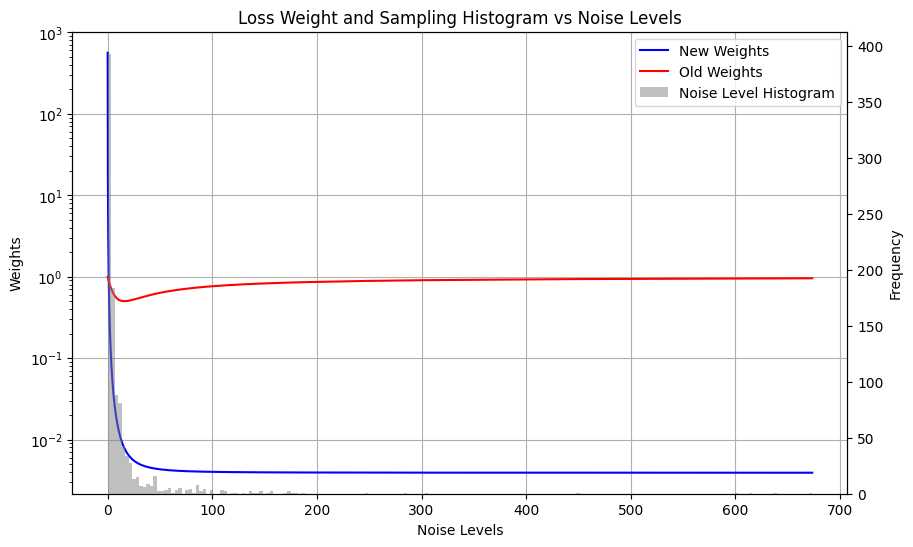

In [5]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the old and new weights vs noise levels
ax1.semilogy(sorted_noise_levels, new_weights, color='blue', label='New Weights')
ax1.semilogy(sorted_noise_levels, old_weights, color='red', label='Old Weights')
ax1.set_xlabel('Noise Levels')
ax1.set_ylabel('Weights')
ax1.grid(True)

# Create a second y-axis for the histogram
ax2 = ax1.twinx()

# Plot the histogram of noise levels
ax2.hist(noise_levels, bins=200, alpha=0.5, color='gray', label='Noise Level Histogram')
ax2.set_ylabel('Frequency')

# Combine the legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

plt.title('Loss Weight and Sampling Histogram vs Noise Levels')
plt.show()

Recall that the purpose of weighting the MSE loss is to downweight the loss function at higher noise levels. The 'optimal' weighting for this, as calculated in the appendices of Karras et al., is plotted above (see the blue line) and clearly demonstrates the intended downweighting of later noise levels.

The old weight values, however, exhibit very different behavior, showing a monotonic increase in weight as the noise level increases (beyond the minimum achieved at $\hat{t} = 16$). This is in stark contrast to what is expected and could, we suspect, greatly impair training.



## Conclusion

We conclude that the weighting of the MSE loss as presented in AF3 Supplementary Material is a typo and will use the corrected weighting, as used in Karras et al., for all required uses in our AF3 implementation.